# Federated Keras MNIST Tutorial

In [ ]:
#Install Tensorflow and MNIST dataset if not installed
!pip install tensorflow==2.3.1

#Alternatively you could use the intel-tensorflow build
# !pip install intel-tensorflow==2.3.0

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

import openfl.native as fx
from openfl.federated import FederatedModel,FederatedDataSet
tf.config.run_functions_eagerly(True)
tf.random.set_seed(0)
np.random.seed(0)

In [ ]:
def test_intel_tensorflow():
    """
    Check if Intel version of TensorFlow is installed
    """
    import tensorflow as tf

    print("We are using Tensorflow version {}".format(tf.__version__))

    major_version = int(tf.__version__.split(".")[0])
    if major_version >= 2:
        from tensorflow.python import _pywrap_util_port
        print("Intel-optimizations (DNNL) enabled:",
              _pywrap_util_port.IsMklEnabled())
    else:
        print("Intel-optimizations (DNNL) enabled:")

test_intel_tensorflow()

After importing the required packages, the next step is setting up our openfl workspace. To do this, simply run the `fx.init()` command as follows:

In [ ]:
#Setup default workspace, logging, etc.
fx.init('keras_cnn_mnist')

Now we are ready to define our dataset and model to perform federated learning on. The dataset should be composed of a numpy arrayWe start with a simple fully connected model that is trained on the MNIST dataset. 

In [ ]:
#Import and process training, validation, and test images/labels

# Set the ratio of validation imgs, can't be 0.0
VALID_PERCENT = 0.3

(X_train, y_train), (X_test, y_test) = mnist.load_data()
split_on = int((1 - VALID_PERCENT) * len(X_train))

train_images = X_train[0:split_on,:,:]
train_labels = to_categorical(y_train)[0:split_on,:]

valid_images = X_train[split_on:,:,:]
valid_labels = to_categorical(y_train)[split_on:,:]

test_images = X_test
test_labels = to_categorical(y_test)

def preprocess(images):
    #Normalize
    images = (images / 255) - 0.5
    images = images.reshape(images.shape[0], -1)
#     images = np.expand_dims(images, axis=-1)
    return images

# Preprocess the images.
train_images = preprocess(train_images)
valid_images = preprocess(valid_images)
test_images = preprocess(test_images)

feature_shape = train_images.shape[1:]
classes = 10

class UnbalancedFederatedDataset(FederatedDataSet):
    def split(self, num_collaborators, shuffle=True, equally=False):
        train_idx = self.split_lognormal(self.y_train, num_collaborators)
        X_train = np.array([self.X_train[idx] for idx in train_idx])
        y_train = np.array([self.y_train[idx] for idx in train_idx])
        
        valid_idx = self.split_lognormal(self.y_valid, num_collaborators)
        X_valid = np.array([self.X_valid[idx] for idx in valid_idx])
        y_valid = np.array([self.y_valid[idx] for idx in valid_idx])
        
        return [
            FederatedDataSet(
                X_train[i],
                y_train[i],
                X_valid[i],
                y_valid[i],
                batch_size=self.batch_size,
                num_classes=self.num_classes
            ) for i in range(num_collaborators)
        ]
    
    def split_lognormal(self, labels, num_collaborators):
        from tqdm import trange
        labels = np.argmax(labels, axis=1)
        idx = [[np.nonzero(labels == (col + j) % self.num_classes)[0][np.arange(5) + (col // 10 * 10 + 5 * j)] \
            for j in range(2)] for col in range(num_collaborators)]
        idx = [np.hstack(tup) for tup in idx]
        assert all([len(i) == 10 for i in idx]), 'All collaborators should have 10 elements at this stage'
        props = np.random.lognormal(0, 2.0, (10,100,2))
        props = np.array([[[len(np.nonzero(labels==label)[0])-1000]] for label in range(10)])*props/np.sum(props,(1,2), keepdims=True)
        #idx = 1000*np.ones(10, dtype=np.int64)
        for user in trange(1000):
            for j in range(2):
                l = (user+j)%10
                num_samples = int(props[l,user//10,j])
                if np.count_nonzero(labels[np.hstack(idx)] == l) + num_samples < len(np.nonzero(labels==l)[0]):
                    idx_to_append = np.nonzero(labels == (user + j) % 10)[0][np.arange(num_samples) + np.count_nonzero(labels[np.hstack(idx)] == l)]
                    idx[user] = np.append(idx[user], idx_to_append)
        return idx

fl_data = UnbalancedFederatedDataset(train_images,train_labels,valid_images,valid_labels,batch_size=32,num_classes=classes)

In [ ]:
from tensorflow.python.ops import standard_ops


@keras.utils.register_keras_serializable()
class FedProxOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.01, mu=0.01, name='FedProxOptimizer', **kwargs):
        super().__init__(name=name, **kwargs)

        self._set_hyper("learning_rate", learning_rate)
        self._set_hyper("mu", mu)

        self._lr_t = None
        self._mu_t = None

    def _prepare(self, var_list):
        self._lr_t = tf.convert_to_tensor(self._get_hyper('learning_rate'), name="lr")
        self._mu_t = tf.convert_to_tensor(self._get_hyper('mu'), name="mu")

    def _create_slots(self, var_list):
        for v in var_list:
            self.add_slot(v, "vstar")

    def _resource_apply_dense(self, grad, var):
        lr_t = tf.cast(self._lr_t, var.dtype.base_dtype)
        mu_t = tf.cast(self._mu_t, var.dtype.base_dtype)
        vstar = self.get_slot(var, "vstar")

        var_update = var.assign_sub(lr_t * (grad + mu_t * (var - vstar)))

        return tf.group(*[var_update, ])

    def _apply_sparse_shared(self, grad, var, indices, scatter_add):
        lr_t = tf.cast(self._lr_t, var.dtype.base_dtype)
        mu_t = tf.cast(self._mu_t, var.dtype.base_dtype)
        vstar = self.get_slot(var, "vstar")
        v_diff = vstar.assign(mu_t * (var - vstar), use_locking=self._use_locking)

        with tf.control_dependencies([v_diff]):
            scaled_grad = scatter_add(vstar, indices, grad)
        var_update = var.assign_sub(lr_t * scaled_grad)

        return tf.group(*[var_update, ])

    def _resource_apply_sparse(self, grad, var):
        return self._apply_sparse_shared(
            grad.values, var, grad.indices,
            lambda x, i, v: standard_ops.scatter_add(x, i, v))

    def get_config(self):
        base_config = super(FedProxOptimizer, self).get_config()
        return {
            **base_config,
            "lr": self._serialize_hyperparameter("learning_rate"),
            "mu": self._serialize_hyperparameter("mu")
        }

In [ ]:
def build_model(input_shape,
                num_classes,
                **kwargs):
    """
    Define the model architecture.

    Args:
        input_shape (numpy.ndarray): The shape of the data
        num_classes (int): The number of classes of the dataset

    Returns:
        tensorflow.python.keras.engine.sequential.Sequential: The model defined in Keras

    """
    model = Sequential()
    
    model.add(tf.keras.Input(shape=input_shape))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=FedProxOptimizer(mu=1),
                  metrics=['accuracy'])

    return model   

In [ ]:
#Create a federated model using the build model function and dataset
fl_model = FederatedModel(build_model, data_loader=fl_data)

The `FederatedModel` object is a wrapper around your Keras, Tensorflow or PyTorch model that makes it compatible with openfl. It provides built in federated training and validation functions that we will see used below. Using it's `setup` function, collaborator models and datasets can be automatically defined for the experiment. 

In [ ]:
collaborator_models = fl_model.setup(num_collaborators=1000)
 
collaborators = {f'col{col}':collaborator_models[col] for col in range(len(collaborator_models))}#, 'three':collaborator_models[2]}

In [ ]:
#Original MNIST dataset
print(f'Original training data size: {len(train_images)}')
print(f'Original validation data size: {len(valid_images)}\n')

#Collaborator one's data
print(f'Collaborator one\'s training data size: {len(collaborator_models[0].data_loader.X_train)}')
print(f'Collaborator one\'s validation data size: {len(collaborator_models[0].data_loader.X_valid)}\n')

#Collaborator two's data
print(f'Collaborator two\'s training data size: {len(collaborator_models[1].data_loader.X_train)}')
print(f'Collaborator two\'s validation data size: {len(collaborator_models[1].data_loader.X_valid)}\n')

#Collaborator three's data
#print(f'Collaborator three\'s training data size: {len(collaborator_models[2].data_loader.X_train)}')
#print(f'Collaborator three\'s validation data size: {len(collaborator_models[2].data_loader.X_valid)}')

We can see the current plan values by running the `fx.get_plan()` function

In [ ]:
#Get the current values of the plan. Each of these can be overridden
import json
print(json.dumps(fx.get_plan(), indent=4, sort_keys=True))

Now we are ready to run our experiment. If we want to pass in custom plan settings, we can easily do that with the `override_config` parameter

In [ ]:
#Run experiment, return trained FederatedModel
final_fl_model = fx.run_experiment(collaborators,override_config={'aggregator.settings.rounds_to_train':5, 'collaborator.settings.opt_treatment': 'CONTINUE_GLOBAL'})

In [ ]:
#Save final model and load into keras
final_fl_model.save_native('final_model')
model = tf.keras.models.load_model('./final_model')

In [ ]:
#Test the final model on our test set
model.evaluate(test_images,test_labels)

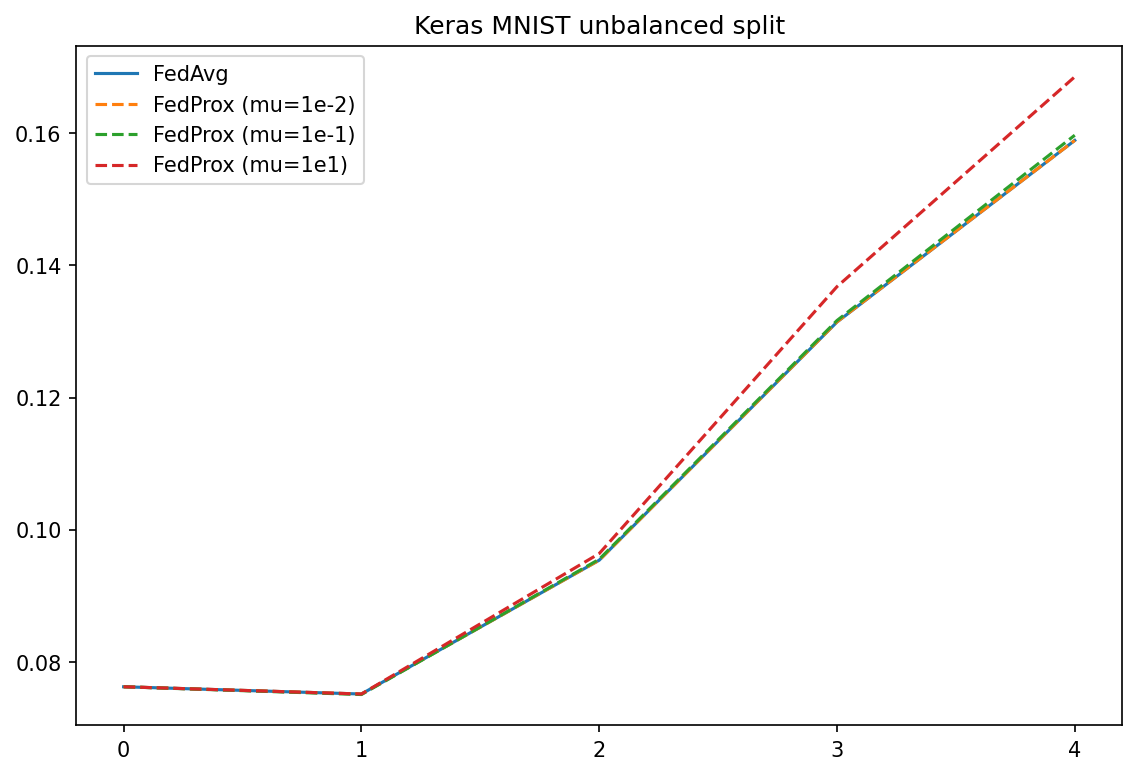

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9,6), dpi=150)
plt.title('Keras MNIST unbalanced split')
plt.plot([0.07627802075538784, 0.07518334008473902, 0.09541350667830556, 0.13141966053564103, 0.15887578643299638], label='FedAvg')
plt.plot([0.07627802075538784, 0.07518334008473902, 0.09541350667830556, 0.1314459763141349, 0.15887578643299638], linestyle='--', label='FedProx (mu=1e-2)')
plt.plot([0.07627802075538784, 0.0751056043850258, 0.09555227747093886, 0.131649036151357, 0.15966261748969554], linestyle='--', label='FedProx (mu=1e-1)')
plt.plot([0.07627802075538784, 0.07517912408802659, 0.09641592293512076, 0.13676991989742965, 0.1684917744528502], linestyle='--', label='FedProx (mu=1e1)')

plt.legend()
plt.xticks(range(5))
plt.show()